In [1]:
from DiffeoOT import *
from utils import *
import torch
import torch.nn.functional as tnn
import time 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
m=32

x = torch.linspace(-1,1,m)
y = torch.linspace(-1,1,m)
grid = torch.zeros((1,m,m,2)).to(dtype=torchdtype, device=torchdeviceId)
for i in range(0,m):
        for j in range(0,m):
            grid[0,i,j,0]= x[i]
            grid[0,i,j,1]= y[j]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


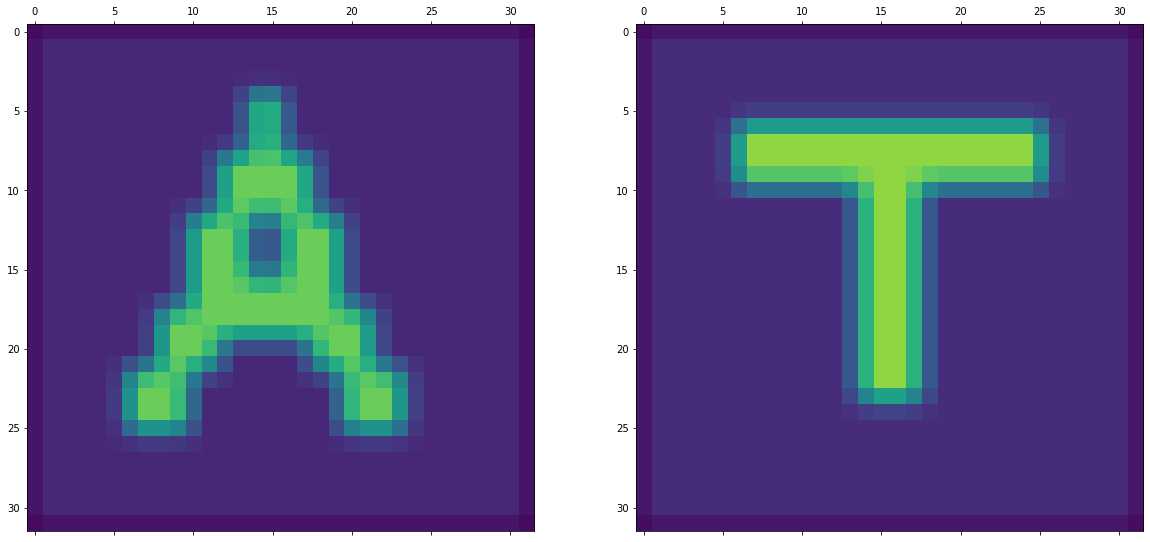

In [11]:
mu_2 = load_dist("T.png",grid)
G1=torch.Tensor([[2,0],[0,2]]).to(dtype=torchdtype, device=torchdeviceId)
mu_1 = load_dist("A.png",grid)
#mu_1 = gaussian(0,0,G1,grid)
plot_pair(mu_1,mu_2)

In [12]:
params=[]
params+=[{'T':6, 'match_coeff':10000, 'path_coeff':1}]

In [13]:
def L(vf):
    vf=torch.unsqueeze(vf,0)
    weight = torch.Tensor([[[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]]]).to(dtype=torchdtype, device=torchdeviceId)
    out = tnn.conv2d(vf,weight.repeat(2,1,1,1), padding='same',groups=2) 
    out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2) 
    out = tnn.conv2d(out,weight.repeat(2,1,1,1), padding='same',groups=2) 
    return out

In [14]:
def inner_prod(X,source,p,grid):
    pm=p[0,0]
    pX= pm*X.transpose(0,2)
    return ((pX**2).sum(dim=0)/(pm)).sum()/(m**2)  

In [15]:
start =time.time()
vecs = DiffeoOT_multires(mu_1,mu_2,grid,params,inner_prod)
print(time.time()-start)
pl_pathlength = path_length(mu_1,vecs,grid,inner_prod)
print(pl_pathlength)
N=vecs.shape[0]

30.66755747795105
[0.02297075 0.02097224 0.02041819 0.02134962 0.0247043 ]


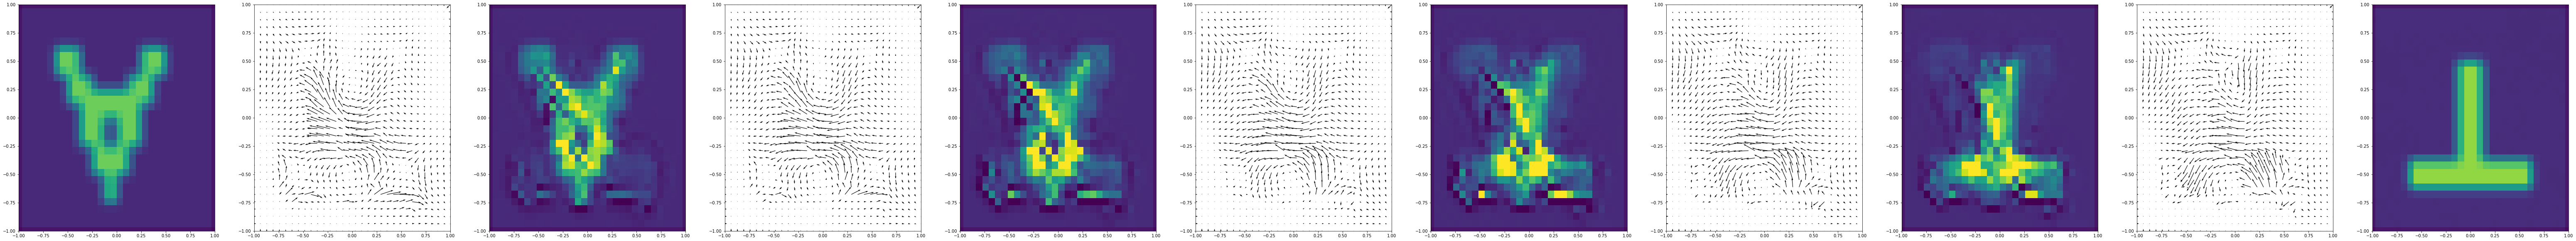

In [16]:
ls = make_and_plot_sequence(mu_1,mu_2,vecs, grid)
save_gif(mu_1,mu_2,ls)

In [17]:
import ot
supports = grid.reshape(m*m,1,2)
costmatrix = ((supports-supports.transpose(0,1))**2).sum(dim=2).cpu().numpy()
m1=mu_1[0,0].reshape(m*m).cpu().numpy()
m2=mu_2[0,0].reshape(m*m).cpu().numpy()

Wd =  ot.sinkhorn2(m1, m2, costmatrix, .0003)
print(Wd)

0.019898476499292893


In [18]:
print(pl_pathlength.sum()/pl_pathlength.shape[0])

0.022083019686470556
